In [1]:
from torchvision.datasets import ImageFolder
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import cv2
import numpy as np
import pandas as pd

transform = transforms.Compose([
    transforms.Resize((50,50)), 
    transforms.ToTensor() 
])

data = ImageFolder(root="./data", transform=transform)
data2 = ImageFolder(root="./data_test", transform=transform)

c:\Users\mathn\.conda\envs\Torch_PY38\lib\site-packages\torchvision\io\image.py:13: UserWarning: Failed to load image Python extension: '[WinError 127] 지정된 프로시저를 찾을 수 없습니다'If you don't plan on using image functionality from `torchvision.io`, you can ignore this warning. Otherwise, there might be something wrong with your environment. Did you have `libjpeg` or `libpng` installed before building `torchvision` from source?
  warn(


In [2]:
data_loader = DataLoader(data, batch_size=10, shuffle=True)
test_loader = DataLoader(data2, batch_size=8, shuffle=True)

In [62]:
images, labels = next(iter(data_loader))
print(images.shape, labels.shape) # shape : [개수, 채널 수, 높이, 너비]

torch.Size([10, 3, 50, 50]) torch.Size([10])


In [63]:
class Mob_Dog(nn.Module): # 클래스 생성
    def __init__(self):
        super(Mob_Dog, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 9 * 9, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x))) # 두번 컨볼루션 연산 해주기
        
        
        
        x = x.view(-1, 16 * 9 * 9)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [64]:
# 모델 객체 생성, 옵티마이저 생성
model = Mob_Dog()
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

In [65]:
def get_accuracy(loader, model):
    total=0
    correct=0
    for data in loader:
        images, labels = data
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1) # dim=1을 주어 최종 값 계산
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    return correct / total

In [66]:
from tqdm import tqdm # 프로그레스 바 생성
from torch.optim.lr_scheduler import ReduceLROnPlateau # 스케줄러 생성 
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=15, verbose=True)

loss_list=[]
tas_list=[]
tes_list=[]
max=0
for epoch in range(100): # 10회 반복 
    running_loss = 0.0 # 1 epoch당 누적 로스값 
    #==================================================================================
    pbar = tqdm(enumerate(data_loader), total=len(data_loader)) 
    for i, data in pbar: # pbar가 데이터 로더 역할 수행
        inputs, labels = data
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() # 로스 누적 
        if i % 10 == 9:
            pbar.set_description(f'Epoch [{epoch + 1}/{10}], 횟수 [{i + 1}/{len(data_loader)}], Loss: {running_loss / 10:.4f}')
            loss_list.append(running_loss)
            running_loss = 0.0
    #==================================================================================   
    # 모델 평가

    with torch.no_grad():
        train_accuracy = get_accuracy(data_loader, model)
        test_accuracy = get_accuracy(test_loader, model)
    print(f'{epoch} Epoch 종료 후 train_score : {(100 * train_accuracy)}')
    print(f'{epoch} Epoch 종료 후 test_score : {(100 * test_accuracy)}')
    tas_list.append(train_accuracy)
    tes_list.append(test_accuracy)
    if max < test_accuracy:
        max = test_accuracy
        torch.save(model.state_dict(), 'model.pth')
    
    scheduler.step(loss)
    if scheduler.num_bad_epochs >= scheduler.patience:
        print(f"Early Stopping at : {epoch} Epoch")
        break

c:\Users\mathn\.conda\envs\Torch_PY38\lib\site-packages\torch\optim\lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
Epoch [1/10], 횟수 [10/18], Loss: 0.6882: 100%|██████████| 18/18 [00:00<00:00, 37.07it/s]


0 Epoch 종료 후 train_score : 51.13636363636363
0 Epoch 종료 후 test_score : 45.67901234567901


Epoch [2/10], 횟수 [10/18], Loss: 0.6572: 100%|██████████| 18/18 [00:00<00:00, 47.70it/s]


1 Epoch 종료 후 train_score : 80.11363636363636
1 Epoch 종료 후 test_score : 80.24691358024691


Epoch [3/10], 횟수 [10/18], Loss: 0.5962: 100%|██████████| 18/18 [00:00<00:00, 51.33it/s]


2 Epoch 종료 후 train_score : 59.65909090909091
2 Epoch 종료 후 test_score : 59.25925925925925


Epoch [4/10], 횟수 [10/18], Loss: 0.5177: 100%|██████████| 18/18 [00:00<00:00, 51.04it/s]


3 Epoch 종료 후 train_score : 78.4090909090909
3 Epoch 종료 후 test_score : 79.01234567901234


Epoch [5/10], 횟수 [10/18], Loss: 0.4712: 100%|██████████| 18/18 [00:00<00:00, 51.25it/s]


4 Epoch 종료 후 train_score : 78.4090909090909
4 Epoch 종료 후 test_score : 76.5432098765432


Epoch [6/10], 횟수 [10/18], Loss: 0.5591: 100%|██████████| 18/18 [00:00<00:00, 48.90it/s]


5 Epoch 종료 후 train_score : 77.27272727272727
5 Epoch 종료 후 test_score : 75.30864197530865


Epoch [7/10], 횟수 [10/18], Loss: 0.5292: 100%|██████████| 18/18 [00:00<00:00, 48.31it/s]


6 Epoch 종료 후 train_score : 77.27272727272727
6 Epoch 종료 후 test_score : 80.24691358024691


Epoch [8/10], 횟수 [10/18], Loss: 0.5087: 100%|██████████| 18/18 [00:00<00:00, 47.85it/s]


7 Epoch 종료 후 train_score : 80.68181818181817
7 Epoch 종료 후 test_score : 80.24691358024691


Epoch [9/10], 횟수 [10/18], Loss: 0.4778: 100%|██████████| 18/18 [00:00<00:00, 48.01it/s]


8 Epoch 종료 후 train_score : 78.4090909090909
8 Epoch 종료 후 test_score : 82.71604938271605


Epoch [10/10], 횟수 [10/18], Loss: 0.5183: 100%|██████████| 18/18 [00:00<00:00, 47.59it/s]


9 Epoch 종료 후 train_score : 80.11363636363636
9 Epoch 종료 후 test_score : 79.01234567901234


Epoch [11/10], 횟수 [10/18], Loss: 0.4535: 100%|██████████| 18/18 [00:00<00:00, 45.91it/s]


10 Epoch 종료 후 train_score : 76.70454545454545
10 Epoch 종료 후 test_score : 77.77777777777779


Epoch [12/10], 횟수 [10/18], Loss: 0.5082: 100%|██████████| 18/18 [00:00<00:00, 49.58it/s]


11 Epoch 종료 후 train_score : 73.86363636363636
11 Epoch 종료 후 test_score : 71.60493827160494


Epoch [13/10], 횟수 [10/18], Loss: 0.5079: 100%|██████████| 18/18 [00:00<00:00, 50.61it/s]


12 Epoch 종료 후 train_score : 82.38636363636364
12 Epoch 종료 후 test_score : 86.41975308641975


Epoch [14/10], 횟수 [10/18], Loss: 0.3928: 100%|██████████| 18/18 [00:00<00:00, 49.86it/s]


13 Epoch 종료 후 train_score : 77.8409090909091
13 Epoch 종료 후 test_score : 82.71604938271605


Epoch [15/10], 횟수 [10/18], Loss: 0.4814: 100%|██████████| 18/18 [00:00<00:00, 52.85it/s]


14 Epoch 종료 후 train_score : 77.27272727272727
14 Epoch 종료 후 test_score : 72.8395061728395


Epoch [16/10], 횟수 [10/18], Loss: 0.3786: 100%|██████████| 18/18 [00:00<00:00, 48.49it/s]


15 Epoch 종료 후 train_score : 84.0909090909091
15 Epoch 종료 후 test_score : 81.48148148148148


Epoch [17/10], 횟수 [10/18], Loss: 0.3717: 100%|██████████| 18/18 [00:00<00:00, 48.50it/s]


16 Epoch 종료 후 train_score : 86.36363636363636
16 Epoch 종료 후 test_score : 82.71604938271605


Epoch [18/10], 횟수 [10/18], Loss: 0.3857: 100%|██████████| 18/18 [00:00<00:00, 48.81it/s]


17 Epoch 종료 후 train_score : 86.36363636363636
17 Epoch 종료 후 test_score : 82.71604938271605


Epoch [19/10], 횟수 [10/18], Loss: 0.3915: 100%|██████████| 18/18 [00:00<00:00, 42.49it/s]


18 Epoch 종료 후 train_score : 86.36363636363636
18 Epoch 종료 후 test_score : 82.71604938271605


Epoch [20/10], 횟수 [10/18], Loss: 0.4468: 100%|██████████| 18/18 [00:00<00:00, 48.99it/s]


19 Epoch 종료 후 train_score : 85.22727272727273
19 Epoch 종료 후 test_score : 87.65432098765432


Epoch [21/10], 횟수 [10/18], Loss: 0.3547: 100%|██████████| 18/18 [00:00<00:00, 49.25it/s]


20 Epoch 종료 후 train_score : 85.79545454545455
20 Epoch 종료 후 test_score : 85.18518518518519


Epoch [22/10], 횟수 [10/18], Loss: 0.3981: 100%|██████████| 18/18 [00:00<00:00, 47.09it/s]


21 Epoch 종료 후 train_score : 79.54545454545455
21 Epoch 종료 후 test_score : 83.9506172839506
Early Stopping at : 21 Epoch


<function matplotlib.pyplot.ylabel(ylabel, fontdict=None, labelpad=None, *, loc=None, **kwargs)>

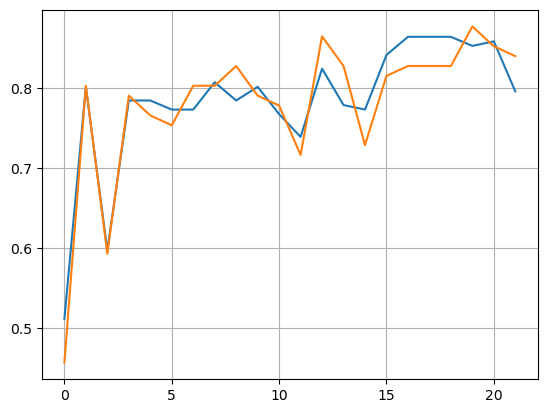

In [67]:
import matplotlib.pyplot as plt

#plt.plot(loss_list)
plt.plot(tas_list)
plt.plot(tes_list)
plt.grid(True)
plt.ylabel

In [82]:
model = Mob_Dog()
model.load_state_dict(torch.load('mob_dog.pth'))
model.eval()

# 이미지 예측
img = cv2.imread('./data/mop_dog/74.jpg')
img = cv2.resize(img, (50, 50))
img = img / 255.0
img = np.transpose(img, (2, 0, 1))
img = torch.Tensor(img)
img = img.unsqueeze(0)

with torch.no_grad():
    output = model(img)
    _, predicted = torch.max(output.data, 1)
predicted, output # 이런 젠장, 걸레라고 나온다 

(tensor([1]), tensor([[-1.3155,  1.4777]]))